# Initialization
This script build the dataframe that will be used for the Machine Learning (ML) part. It reads in the KunsatDB and add additional feature based on localisation. It also perform some encoding of categorical features.

In [3]:
import ast
import glob
import math
import os
import pickle
import random
import statistics
import geopandas as gpd
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import statsmodels.api as s
from IPython.display import Image, Markdown, display
from rasterio.plot import show
from tqdm.notebook import tqdm, trange
import missingno as msno
import folium
from folium.plugins import BeautifyIcon
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')

data_dir = "../wd/"

sns.set(rc={"figure.figsize":(14, 6)}, font_scale=1.3) 
sns.set_style("ticks")

In [9]:
# load df, if xlsx file has multiple sheets all are stored in a dictionary
NickJohnDB = pd.read_excel(data_dir + "OTIM-DB.xlsx", sheet_name=None)

# split dict into important sheets
NickJohnDB_comb = NickJohnDB["experiments"]
NickJohnDB_loc = NickJohnDB['locations']
NickJohnDB_climate = NickJohnDB["climate"]
NickJohnDB_method = NickJohnDB['method']
NickJohnDB_fit = NickJohnDB['modelFit']
NickJohnDB_ref = NickJohnDB['reference']
NickJohnDB_soil = NickJohnDB['soilProperties']
NickJohnDB_management = NickJohnDB['soilManagement']

# Functions

In [10]:
def onehot_landuse(df, column, new_column, value_list):
    """The function searches a column of an df that contains 
    multiple entries seperated e.g. crop rotation for 
    certain keywords given in a list and returns a new binary
    column for this keywords e.g. rotation contains cereals.

    Parameters
    ----------
    df : dataframe
        Original dataframe that should be used.

    column : string
        Name if column that should be searched.

    new_column : string
        Name of new column that is generated.

    value_list : list
        List of values that functions as key words for the search.

    Returns:
    --------
        No Returns. New column is generated in the used dataframe
    """
    df[new_column] = "no"
    df.loc[df[column].replace(np.nan, "unknown").str.contains(r'\b(?:{})\b'.format('|'.join(value_list))), new_column] = "yes"


def kMeansRes(scaled_data, k, alpha_k=0.02):
    '''Perform a kmean based on a matrix with feature in column
    and sample in rows. Returns the scaled inertia of the groups.

    Parameters 
    ----------
    scaled_data : numpy.array (2D)
        Scaled data. Rows are samples and columns are features for clustering.
    k : int
        Current k for applying KMeans.
    alpha_k : float
        Manually tuned factor that gives penalty to the number of clusters.

    Returns 
    -------
    scaled_inertia : float
        scaled inertia value for current k
    '''
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    # fit k-means
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia


def chooseBestKforKMeans(scaled_data, k_range):
    ans = []
    for k in k_range:
        scaled_inertia = kMeansRes(scaled_data, k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns = ['k', 'Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results

# Data preparation

In [11]:
# merging the different dataframe on the experiment sheet, which serves as key sheet 
df = NickJohnDB_comb.merge(
    NickJohnDB_loc, how="left", left_on="Location",  right_on="Location").merge(
    NickJohnDB_ref, how="left", left_on="ReferenceTag", right_on="ReferenceTag").merge(
    NickJohnDB_method, how="left", left_on="MethodName", right_on="MethodName").merge(
    NickJohnDB_soil, how="left", left_on="SPName", right_on="SPName").merge(
    NickJohnDB_climate, how="left").merge(
    NickJohnDB_fit, how="left").merge(
    NickJohnDB_management, how="left")

In [12]:
# cleaning values (replace -9999 by np.nan)
col_obj = df.select_dtypes(include=["object"]).columns.to_list()
col_num = df.select_dtypes(include=["float64", "int64"]).columns.to_list()

df = df.replace(["-", "unknown", -9999], np.nan)
NickJohnDB_loc = NickJohnDB_loc.replace(["-", "unknown", -9999], np.nan)

In [13]:
# generating corresponding log values for K
k_list = [
 'Ks',
 'K1',
 'K2',
 'K3',
 'K4',
 'K5',
 'K6',
 'K7',
 'K8',
 'K9',
 'K10']

for i in k_list:
    df["log_" + i] = np.log10(df[i])

## Climate Data 
In this section, additional climatic data are added based on location. They are extracted from raster from the bioclim database (https://www.worldclim.org/data/worldclim21.html).

References:
- BioClim: Fick, Stephen E., and Robert J. Hijmans. 2017. “WorldClim 2: New 1‐km Spatial Resolution Climate Surfaces for Global Land Areas.” International Journal of Climatology 37 (12): 4302–15. https://doi.org/10.1002/joc.5086.
- Global Aridity Index and Potential Evapotranspiration: Trabucco, Antonio, and Robert Zomer. 2018. “Global Aridity Index and Potential Evapotranspiration (ET0) Climate Database V2.” figshare. https://doi.org/10.6084/M9.FIGSHARE.7504448.V1.


In [17]:
# create dict with directory and he column name for df
bioclim_dic = {
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_1.tif' : "AnnualMeanTemperature",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_2.tif' : "MeanDiurnalRange",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_3.tif' : "Isothermality",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_4.tif' : "TemperatureSeasonality",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_5.tif' : "MaxTemperatureofWarmestMonth",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_6.tif' : "MinTemperatureofColdestMonth",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_7.tif' : "TemperatureAnnualRange",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_8.tif' : "MeanTemperatureofWettestQuarter",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_9.tif' : "MeanTemperatureofDriestQuarter",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_10.tif' : "MeanTemperatureofWarmestQuarter",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_11.tif' : "MeanTemperatureofColdestQuarter",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_12.tif' : "AnnualPrecipitation",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_13.tif' : "PrecipitationofWettestMonth",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_14.tif' : "PrecipitationofDriestMonth",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_15.tif' : "PrecipitationSeasonality",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_16.tif' : "PrecipitationofWettestQuarter",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_17.tif' : "PrecipitationofDriestQuarter",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_18.tif' : "PrecipitationofWarmestQuarter",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_bio_19.tif' : "PrecipitationofColdestQuarter",
 data_dir + 'wc2.1_30s_bio/wc2.1_30s_elev.tif' : "Elevation"   
}

PET_dic = {
   data_dir+'7504448/global-ai-et0/ai_et0.tif' : "AverageAridityIndex",
   data_dir+'7504448/global-et0_annual/et0_yr.tif' : "AverageAnnualEvapoTranspiration"
}

In [15]:
# loop trough index (without na's) in final df and the location sheet (for providing the data in the final data base version)
# reading the raster and transforming the corresponding lat and long into an index that is than search in the raster
# class for aridity are provided by original data as well the conversion for the "AverageAridityIndex"

all_filenames = list(PET_dic.keys())

for file in tqdm(all_filenames):
    Raster = rasterio.open(file)
    Raster_read = Raster.read(1)
    for index in tqdm(df[["Latitude", "Longitude"]].dropna().index):
        x = df.loc[index, "Longitude"]
        y = df.loc[index, "Latitude"]
        row, col = Raster.index(x, y)
        df.loc[index, PET_dic[file]] = Raster_read[row, col]
    for index2 in tqdm(NickJohnDB_loc[["Latitude", "Longitude"]].dropna().index):
        x = NickJohnDB_loc.loc[index2, "Longitude"]
        y = NickJohnDB_loc.loc[index2, "Latitude"]
        row, col = Raster.index(x, y)
        NickJohnDB_loc.loc[index2, PET_dic[file]] = Raster_read[row, col]

# attribution of aridity class
df["AverageAridityIndex"] = df["AverageAridityIndex"] * 0.0001
df["AridityClass"] = "none"
df.loc[df["AverageAridityIndex"] < 0.03, "AridityClass"] = "Hyper Arid"
df.loc[df["AverageAridityIndex"].between(0.03, 0.2), "AridityClass"] = "Arid"
df.loc[df["AverageAridityIndex"].between(0.2, 0.5), "AridityClass"] = "Semi-Arid"
df.loc[df["AverageAridityIndex"].between(0.5, 0.65), "AridityClass"] = "Dry sub-humid"
df.loc[df["AverageAridityIndex"] > 0.65, "AridityClass"] = "Humid"

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

In [18]:
# adding information from all other rasters
all_filenames = list(bioclim_dic.keys())

for file in tqdm(all_filenames):
    Raster = rasterio.open(file)
    Raster_read = Raster.read(1)
    for index in tqdm(df[["Latitude", "Longitude"]].replace(-9999, np.nan).dropna().index):
        x = df.loc[index, "Longitude"]
        y = df.loc[index, "Latitude"]
        row, col = Raster.index(x, y)
        df.loc[index, bioclim_dic[file]] = Raster_read[row, col]
    for index2 in tqdm(NickJohnDB_loc[["Latitude", "Longitude"]].dropna().index):
        x = NickJohnDB_loc.loc[index2, "Longitude"]
        y = NickJohnDB_loc.loc[index2, "Latitude"]
        row, col = Raster.index(x, y)
        NickJohnDB_loc.loc[index2, bioclim_dic[file]] = Raster_read[row, col]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

In [19]:
# saving location sheet for later use in the database
NickJohnDB_loc.to_csv(data_dir + "KunsatDB_climate.csv")

## Soil type data
Complete the missing soil type from most probable soil type from worldwide raster. The lookup table for the correspondance between the Soil_code and the Soil is given in the .rat.xml file.

In [20]:
from owslib.wcs import WebCoverageService

# raster for soil type has to be laoded trought this package handeling wcm files
# Coverage service
var = "wrb"
url = "http://maps.isric.org/mapserv?map=/map/{}.map".format(var)
wcs = WebCoverageService(url, version='1.0.0')

In [21]:
cov_list = list(wcs.contents)
print(cov_list)

['Acrisols', 'Albeluvisols', 'Alisols', 'Andosols', 'Arenosols', 'Calcisols', 'Cambisols', 'Chernozems', 'Cryosols', 'Durisols', 'Ferralsols', 'Fluvisols', 'Gleysols', 'Gypsisols', 'Histosols', 'Kastanozems', 'Leptosols', 'Lixisols', 'Luvisols', 'MostProbable', 'Nitisols', 'Phaeozems', 'Planosols', 'Plinthosols', 'Podzols', 'Regosols', 'Solonchaks', 'Solonetz', 'Stagnosols', 'Umbrisols', 'Vertisols']


In [22]:
variable = 'MostProbable'
bbox = (-180, -90, 180, 90)
crs = 'urn:ogc:def:crs:EPSG::4326'
resolution = 0.2

# Get the data
response = wcs.getCoverage(
    identifier=variable, 
    crs=crs,
    bbox=bbox, 
    resx=resolution,
    resy=resolution, 
    format='GEOTIFF_INT16')

# Save the data as geotif
outputname = data_dir + "{}.tif".format(variable)
with open(outputname, 'wb') as file:
    file.write(response.read())

In [23]:
# loading self created xlsx with conversion from numeric values to soil type name
soil_df = pd.read_excel(data_dir + "wrbfu.xlsx")
soil_name_dict = dict(zip(list(soil_df["Soil_code"]), list(soil_df["Soil"])))
agreement = {'agree': 0, 'not agree': 0}
Raster = rasterio.open(data_dir + 'MostProbable.tif')
Raster_read = Raster.read(1)
for index in tqdm(df[["Latitude", "Longitude"]].replace(-9999, np.nan).dropna().index):
    x = df.loc[index, "Longitude"]
    y = df.loc[index, "Latitude"]
    row, col = Raster.index(x, y)
    soil_type = soil_name_dict[Raster_read[row, col]]
    # we only replace the soil type if it is not provided in the paper
    st = df.loc[index, 'SoilTypeClass']
    if pd.isna(st) == True:
        df.loc[index, 'SoilTypeWRB'] = soil_type
    else:
        sts = st.split(',')
        df.loc[index, 'SoilTypeWRB'] = sts[0]  # we just take the first one for simplicity really
        if soil_type in sts:
            agreement['agree'] += 1
        else:
            agreement['not agree'] += 1
            #print('in paper:', df.loc[index, 'SoilTypeWRB'], 'in SoilGrids:', soil_type)
agreement

  0%|          | 0/1296 [00:00<?, ?it/s]

{'agree': 238, 'not agree': 424}

In [24]:
df[df['Latitude'].isna()]['ReferenceTag']

305    Zohrabi_2012_AiEB
Name: ReferenceTag, dtype: object

## Handling crop rotation
Crop rotation are decomposed in columns "containsCereal", "containsGrass", ... with yes/no inside.

In [25]:
# put default crop rotation to 1 as they are used as weights
df.loc[df['NbOfCropRotation'].isna(), 'NbOfCropRotation'] = 1

In [26]:
# defining key words for choosen categorys for semi one hot encoding
# Crops/Crop rotation
cereals = ['Wheat','Grain Sorghum','Winter Wheat','Winter Barley','Barley','Cereals','Sorghum','Spring Wheat','Durum Wheat','Winter Durum Wheat','winter wheat (Triticum aestivum L.)','oats','unkown cereal','durum wheat (2010)','Barley ',' Sorghum',' Spring Wheat','Winter Barely ',' Spring Barley',' Srping Barley',' Wheat',' Winter Wheat',' winter wheat (2008)',' Barley',' durum wheat (2012)',' Triticale',' winter wheat ','Millet']
fallow = ['Fallow',' "Fallow"',' Fallow']
grass_herbs = [' eriophorum spp',' phacelia tanacetifolia',' sphagnum spp','calluna','Hairy Vetch','Rye Grass','Needlegrass','Grass','vetch','grassland','spontaneous herbaceous vegentation','herbaceous vegetation','velvet',' Herbs','Meadow Fescue',' Rye Grass',' tussock grass','herbaceous species','Phacelia','Timothy']
legume = ['Alfalfa','Soybean','Peashrub','Lucerne','Clover','Snail Medic','Chickpea','Medic','peas','pea',' Bean',' Pea',' Soybean',' Peas',' Lucerne',' Grain Legumes',' pea (2011)',' Alfalfa',' Spring Pea',' Lentli ',' Lupin',' Red Clover','clover ley']
maize = [' Maize','Maize','Corn',' corn',' Sweet Corn']
trees_fruits = ['Andansonia Digitata L. ','Ash','Cotton','trees','eucalyptus plantation','citrus','vineyard','orchard','olive grove','Acacia trees ','apple orchard',' Sycamore',' Parkia Biglobosa (Fruits)',' citrus']
vegetables = ['Sugar Beet','Potatoes','Carrot','Onion',' sugar beet (Beta vulgaris L.)',' vegetables',' Sugar Beet',' sugar beet ']

In [27]:
# applingy semi one hot encoding on given data

onehot_landuse(df, "CropRotation", "ContainsCereals", cereals)
onehot_landuse(df, "CropRotation", "ContainsFallow", fallow)
onehot_landuse(df, "CropRotation", "ContainsGrassHerbs", grass_herbs)
onehot_landuse(df, "CropRotation", "ContainsLegume", legume)
onehot_landuse(df, "CropRotation", "ContainsMaize", maize)
onehot_landuse(df, "CropRotation", "ContainsTreesFruits", trees_fruits)
onehot_landuse(df, "CropRotation", "ContainsVegetables", vegetables)

# adding yes in the fields if some crops are mentioned in the current crop column, but have no values in the crop rotation

df.loc[df["CropClass"].replace(np.nan, "unknown").str.contains(r'\b(?:{})\b'.format('|'.join(cereals))), "ContainsCereals"] = "yes"
df.loc[df["CropClass"].replace(np.nan, "unknown").str.contains(r'\b(?:{})\b'.format('|'.join(fallow))), "ContainsFallow"] = "yes"
df.loc[df["CropClass"].replace(np.nan, "unknown").str.contains(r'\b(?:{})\b'.format('|'.join(grass_herbs))), "ContainsGrassHerbs"] = "yes"
df.loc[df["CropClass"].replace(np.nan, "unknown").str.contains(r'\b(?:{})\b'.format('|'.join(legume))), "ContainsLegume"] = "yes"
df.loc[df["CropClass"].replace(np.nan, "unknown").str.contains(r'\b(?:{})\b'.format('|'.join(maize))), "ContainsMaize"] = "yes"
df.loc[df["CropClass"].replace(np.nan, "unknown").str.contains(r'\b(?:{})\b'.format('|'.join(trees_fruits))), "ContainsTreesFruits"] = "yes"
df.loc[df["CropClass"].replace(np.nan, "unknown").str.contains(r'\b(?:{})\b'.format('|'.join(vegetables))), "ContainsVegetables"] = "yes"

### Seasons

In [28]:
# converting season to numeric for encoding cyclic varaibles 
df["Season_num"] = df["Season"].replace({"spring": 0, "summer": 1, "autumn": 2, "winter": 3})

In [29]:
# converting all cyclic featues to a sin and cos to create a real relationship
# and the end divided by max value -> month = 12 and season = 4

df['Month1_sin'] = np.sin(2 * np.pi * df[df["Month1"]!=-9999]["Month1"]/12.0)
df['Month1_cos'] = np.cos(2 * np.pi * df[df["Month1"]!=-9999]["Month1"]/12.0)

df['Month2_sin'] = np.sin(2 * np.pi * df[df["Month2"]!=-9999]["Month2"]/12.0)
df['Month2_cos'] = np.cos(2 * np.pi * df[df["Month2"]!=-9999]["Month2"]/12.0)

df['Season_sin'] = np.sin(2 * np.pi * df[df["Season_num"]!=-9999]["Season_num"]/3.0)
df['Season_cos'] = np.cos(2 * np.pi * df[df["Season_num"]!=-9999]["Season_num"]/3.0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


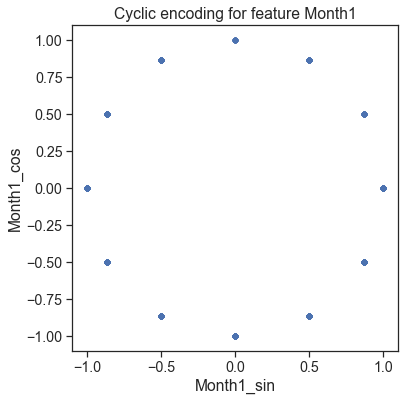

In [31]:
# with this two features now e.g. December and January are closer than December and October,
# which would not be the case if those features were linear
df.plot.scatter('Month1_sin', 'Month1_cos').set_aspect('equal')
plt.title("Cyclic encoding for feature Month1")
plt.savefig(data_dir + "Month1_cyclic.JPEG")

### Outliers

Reasons:
- R2 of the fit K(h) vs h is < 0.8 (mostly references from Yusuf2018, Yusuf2020, wang2022)
- Organic soil with SOC > 0.8

In [32]:
# clean outliers

# only keep entries which have at least an R2 of 0.8
i2keep = df['R2'].gt(0.9)
df = df[i2keep]
print('{:d} entries removed'.format(np.sum(~i2keep)))

# discard entries on organic soil
i2keep = df['SoilOrganicCarbon'].lt(0.8)
df = df[i2keep]
print('{:d} entries removed'.format(np.sum(~i2keep)))

# reset index
df = df.reset_index(drop=True)
print('{:d} entries remaining'.format(df.shape[0]))

123 entries removed
312 entries removed
862 entries remaining


In [33]:
# save final database with additional metadata
df.to_excel(data_dir+"KunsatDB_prep.xlsx")

In [34]:
# melt and groupby to have number of entries per tension
K_df = pd.melt(df, id_vars=['ExID'], value_vars=['Ks', 'K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10'],
        var_name='K_name', value_name='K_value').groupby("K_name").count()["K_value"].reset_index()
K_df["K_name"]=pd.Categorical(K_df["K_name"],categories=reversed(['Ks','K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10']))
K_df = K_df.sort_values('K_name')

Text(0.5, 1.0, 'Database entries for different hydraulic conductivites')

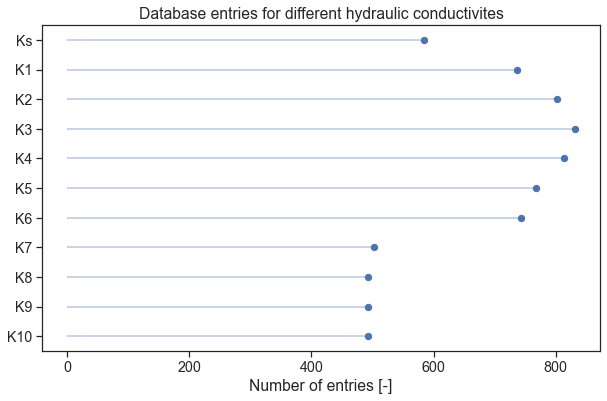

In [35]:
# figure
fig = plt.figure(figsize=(10, 6))
plt.hlines(y=K_df["K_name"], xmin=0, xmax=K_df["K_value"], alpha=0.4)
plt.scatter(K_df["K_value"], K_df["K_name"], s=40, alpha=1)
plt.xlabel("Number of entries [-]")
plt.title("Database entries for different hydraulic conductivites")